<a href="https://colab.research.google.com/github/raultyv/Tareas/blob/main/playas_TSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving 2025-07-17-00_00_2025-07-17-23_59_Sentinel-2_L2A_B03_(Raw).tiff to 2025-07-17-00_00_2025-07-17-23_59_Sentinel-2_L2A_B03_(Raw) (6).tiff
Saving 2025-07-17-00_00_2025-07-17-23_59_Sentinel-2_L2A_B04_(Raw).tiff to 2025-07-17-00_00_2025-07-17-23_59_Sentinel-2_L2A_B04_(Raw) (6).tiff
Saving 2025-07-17-00_00_2025-07-17-23_59_Sentinel-2_L2A_B08_(Raw).tiff to 2025-07-17-00_00_2025-07-17-23_59_Sentinel-2_L2A_B08_(Raw) (6).tiff
Saving 2025-07-17-00_00_2025-07-17-23_59_Sentinel-2_L2A_B11_(Raw).tiff to 2025-07-17-00_00_2025-07-17-23_59_Sentinel-2_L2A_B11_(Raw) (6).tiff
Saving 2025-07-17-00_00_2025-07-17-23_59_Sentinel-2_L2A_B12_(Raw).tiff to 2025-07-17-00_00_2025-07-17-23_59_Sentinel-2_L2A_B12_(Raw) (6).tiff
Saving 2025-07-17-00_00_2025-07-17-23_59_Sentinel-2_L2A_B02_(Raw).tiff to 2025-07-17-00_00_2025-07-17-23_59_Sentinel-2_L2A_B02_(Raw) (6).tiff
Archivo subido: "2025-07-17-00_00_2025-07-17-23_59_Sentinel-2_L2A_B03_(Raw) (6).tiff" (con tamaño 120448 bytes)
Archivo subido: "2025-07-17-00_00_20

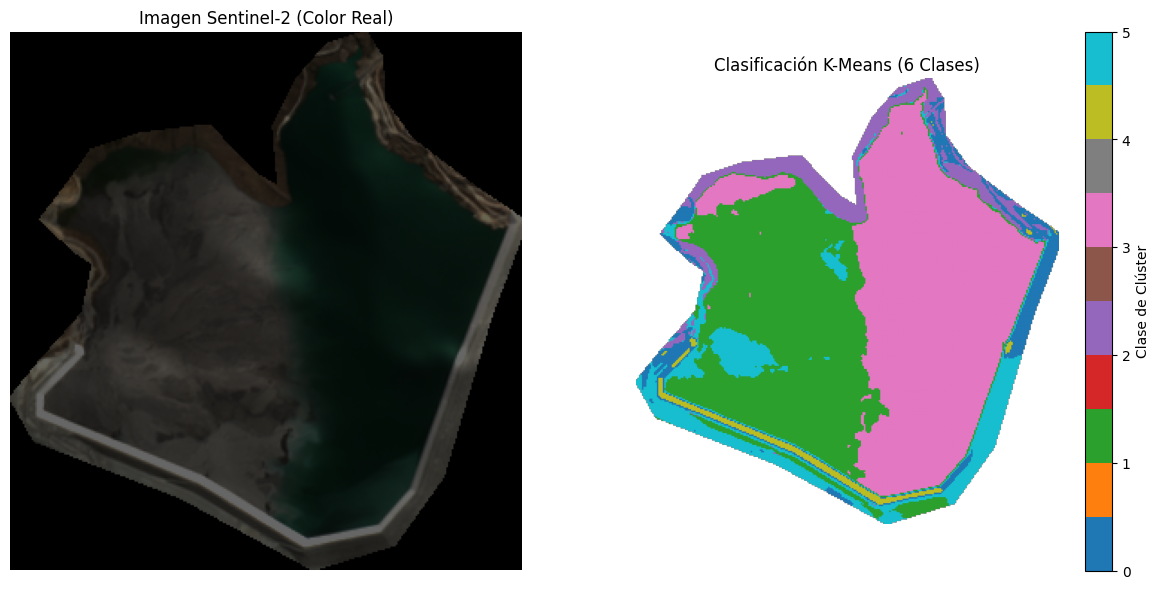


Interpretación de las clases (basada en los centroides del clúster):
--- Centroides de los Clústeres (Reflectancia Promedio por Banda) ---
Clase 0:
  B2: 0.2602
  B3: 0.2925
  B4: 0.3111
  B8: 0.3268
  B11: 0.3542
  B12: 0.3224
------------------------------
Clase 1:
  B2: 0.1376
  B3: 0.1492
  B4: 0.1539
  B8: 0.1471
  B11: 0.0779
  B12: 0.0611
------------------------------
Clase 2:
  B2: 0.0889
  B3: 0.1158
  B4: 0.1396
  B8: 0.2337
  B11: 0.2946
  B12: 0.2371
------------------------------
Clase 3:
  B2: 0.0579
  B3: 0.0789
  B4: 0.0317
  B8: 0.0073
  B11: 0.0083
  B12: 0.0084
------------------------------
Clase 4:
  B2: 0.5016
  B3: 0.5244
  B4: 0.5362
  B8: 0.5283
  B11: 0.4344
  B12: 0.3531
------------------------------
Clase 5:
  B2: 0.1876
  B3: 0.2053
  B4: 0.2116
  B8: 0.2123
  B11: 0.2064
  B12: 0.1928
------------------------------

Para interpretar cada Clase (0, 1, 2...):
1. **Relave Activo / Agua Turbia:** Busca una clase con reflectancia MUY BAJA en B8 (NIR), B11 (S

In [8]:
from google.colab import files

uploaded = files.upload()

for filename in uploaded.keys():
    print(f'Archivo subido: "{filename}" (con tamaño {len(uploaded[filename])} bytes)')

# Después de subir, tus archivos estarán en la carpeta de trabajo actual,
# que usualmente es /content/
# Por ejemplo, si subiste 'B02.tiff', lo encontrarás en '/content/B02.tiff'
!pip install rasterio scikit-learn
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.cluster import KMeans # Necesaria para K-Means

# 1. Definir la ruta a tus imágenes en Google Colab
# Asumiendo que subiste los archivos a la carpeta por defecto /content/
image_folder = '/content/'

# 2. Cargar las Bandas de Interés
# Nombres de los archivos JP2 (ahora .tiff) y sus rutas.
# ¡IMPORTANTE!: Ajusta el prefijo '2025-07-17-00_00_2025-07-17-23_59_Sentinel-2_L2A_'
# si tus nombres de archivo son diferentes.
# Y asegúrate de que terminan en '_B02_Raw.tiff', '_B03_Raw.tiff', etc.
band_files = {
    'B2': os.path.join(image_folder, '2025-07-17-00_00_2025-07-17-23_59_Sentinel-2_L2A_B02_(Raw).tiff'),
    'B3': os.path.join(image_folder, '2025-07-17-00_00_2025-07-17-23_59_Sentinel-2_L2A_B03_(Raw).tiff'),
    'B4': os.path.join(image_folder, '2025-07-17-00_00_2025-07-17-23_59_Sentinel-2_L2A_B04_(Raw).tiff'),
    'B8': os.path.join(image_folder, '2025-07-17-00_00_2025-07-17-23_59_Sentinel-2_L2A_B08_(Raw).tiff'),
    'B11': os.path.join(image_folder, '2025-07-17-00_00_2025-07-17-23_59_Sentinel-2_L2A_B11_(Raw).tiff'),
    'B12': os.path.join(image_folder, '2025-07-17-00_00_2025-07-17-23_59_Sentinel-2_L2A_B12_(Raw).tiff')
}

stacked_bands = []
band_names = []

# Tomaremos la primera banda de 10m (ej. B02) como referencia para el perfil y la forma.
# Si tus imágenes son de un área específica y todas las bandas tienen la misma resolución
# (por ejemplo, todas remuestreadas a 10m en la descarga), este paso de remuestreo
# puede ser menos crítico o necesitar un ajuste.
ref_band_path = band_files['B2'] # Usamos B2 como referencia de 10m (o la resolución más alta)

try:
    with rasterio.open(ref_band_path) as src:
        profile = src.profile
        out_shape = src.shape # Obtener la forma (filas, columnas) de la banda de referencia

    # Para las imágenes descargadas de Copernicus Browser Analytical,
    # es posible que ya vengan con la resolución solicitada y no necesiten remuestreo,
    # pero el código está preparado por si acaso.
    for band_name, file_path in band_files.items():
        if not os.path.exists(file_path):
            print(f"Advertencia: Archivo {file_path} no encontrado. Asegúrate de que la ruta y el nombre del archivo sean correctos.")
            continue

        with rasterio.open(file_path) as src:
            # Leer la banda. Sentinel-2 L2A se escala por 10000.
            # Los TIFF de 32-bit float ya pueden tener el valor correcto (0-1),
            # pero una revisión rápida de src.profile['dtype'] y los valores
            # te dirá si necesitas dividir. Si los valores son grandes (ej. > 1), divídelos.
            band_data = src.read(1).astype(np.float32)

            # Si son valores de reflectancia de 0 a 1, no es necesario dividir.
            # Pero si son enteros grandes (0-10000), entonces sí:
            if np.max(band_data) > 1.0: # Heurística simple para detectar si es necesario escalar
                band_data = band_data / 10000.0


            # Remuestreo si la resolución es diferente
            if src.res != (profile['transform'].a, abs(profile['transform'].e)):
                print(f"Remuestreando banda {band_name} de {src.res} a {(profile['transform'].a, abs(profile['transform'].e))}...")
                from skimage.transform import resize
                band_data = resize(band_data, out_shape, anti_aliasing=True)

            stacked_bands.append(band_data)
            band_names.append(band_name)

except rasterio.errors.RasterioIOError as e:
    print(f"Error al abrir archivo de referencia {ref_band_path}: {e}")
    print("Por favor, verifica que el archivo existe y es legible.")
    stacked_bands = [] # Asegurar que la lista esté vacía para detener el proceso

if not stacked_bands:
    print("Error: No se pudieron cargar bandas. Verifique las rutas y los nombres de los archivos.")
else:
    # Apilar las bandas en un array numpy (Filas, Columnas, Bandas)
    image_array = np.stack(stacked_bands, axis=-1)
    print(f"Forma del array de imagen: {image_array.shape}")
    print(f"Bandas cargadas en orden: {band_names}")

    # --- 4. Preparar los datos para K-Means ---
    # Remodelar el array de imagen de (filas, columnas, bandas) a (píxeles, bandas)
    reshaped_image = image_array.reshape(-1, image_array.shape[-1])

    # Filtrar píxeles que son completamente negros (usualmente NoData fuera del área de imagen)
    # np.all(reshaped_image == 0, axis=1) verifica si todos los valores en la fila son 0
    data_for_kmeans = reshaped_image[~np.all(reshaped_image == 0, axis=1)]

    print(f"Forma de los datos para K-Means (después de filtrar NoData): {data_for_kmeans.shape}")

    # 5. Ejecutar K-Means
    num_clusters = 6 # Puedes ajustar este número a 4 o 5 si observas más diferenciación
    print(f"Ejecutando K-Means con {num_clusters} clústeres...")

    kmeans = KMeans(n_clusters=num_clusters, n_init='auto', random_state=42)
    kmeans.fit(data_for_kmeans)

    # Predecir las etiquetas para todos los píxeles originales (incluyendo los que eran 0)
    # Crearemos un array de etiquetas del mismo tamaño que `reshaped_image`
    # Y luego rellenaremos las posiciones de los píxeles filtrados con un valor especial (ej. -1 o np.nan)
    labels_full_shape = np.full(reshaped_image.shape[0], -1, dtype=int) # Usar -1 para NoData
    labels_full_shape[~np.all(reshaped_image == 0, axis=1)] = kmeans.predict(data_for_kmeans)

    # Remodelar las etiquetas de nuevo a la forma de la imagen original
    classified_map = labels_full_shape.reshape(image_array.shape[0], image_array.shape[1])

    # 6. Visualizar los resultados
    plt.figure(figsize=(15, 7)) # Aumentar el tamaño para mejor visualización

    # Visualización de Color Real (RGB)
    try:
        idx_b4 = band_names.index('B4')
        idx_b3 = band_names.index('B3')
        idx_b2 = band_names.index('B2')
        rgb_image = image_array[:, :, [idx_b4, idx_b3, idx_b2]] # Orden RGB
        # Normalizar para visualización. Los valores entre 0 y 1.
        # Ajusta min/max para buena visualización de tu escena.
        rgb_display = np.clip(rgb_image, 0.0, 0.4) # Ajusta estos valores si tu imagen es muy brillante/oscura
        plt.subplot(1, 2, 1)
        plt.imshow(rgb_display)
        plt.title('Imagen Sentinel-2 (Color Real)')
        plt.axis('off')
    except ValueError:
        print("No se encontraron todas las bandas B2, B3, B4 para la visualización RGB.")
        plt.subplot(1, 2, 1) # Crear un subplot vacío si no hay RGB

    # Visualización de la clasificación K-Means
    plt.subplot(1, 2, 2)
    # cmap='tab10' o 'Paired' son buenas opciones para clases discretas.
    # Necesitamos enmascarar los valores de -1 (NoData) para que no se clasifiquen.
    masked_classified_map = np.ma.masked_where(classified_map == -1, classified_map)

    plt.imshow(masked_classified_map, cmap='tab10', vmin=0, vmax=num_clusters-1)
    plt.title(f'Clasificación K-Means ({num_clusters} Clases)')
    cbar = plt.colorbar(label='Clase de Clúster', ticks=np.arange(num_clusters))
    cbar.set_ticklabels([str(i) for i in range(num_clusters)]) # Pone los números de clase
    plt.axis('off')
    plt.show()

    # --- 7. Interpretación de las Clases (CRUCIAL) ---
    print("\nInterpretación de las clases (basada en los centroides del clúster):")
    print("--- Centroides de los Clústeres (Reflectancia Promedio por Banda) ---")
    cluster_centers = kmeans.cluster_centers_
    for i, center_values in enumerate(cluster_centers):
        print(f"Clase {i}:")
        for j, band_val in enumerate(center_values):
            print(f"  {band_names[j]}: {band_val:.4f}") # Formatear a 4 decimales
        print("-" * 30)

    print("\nPara interpretar cada Clase (0, 1, 2...):")
    print("1. **Relave Activo / Agua Turbia:** Busca una clase con reflectancia MUY BAJA en B8 (NIR), B11 (SWIR1) y B12 (SWIR2).")
    print("2. **Relave Húmedo:** Busca una clase con reflectancia BAJA a MODERADA en B8, B11 y B12, pero significativamente más alta que la del agua.")
    print("3. **Relave Seco:** Busca una clase con reflectancia ALTA en B8, B11 y B12.")
    print("4. **Otras Coberturas (si hay):** Si hay vegetación, tendrá alta reflectancia en B8 (NIR) y baja en B4 (Rojo). Suelo desnudo/rocas pueden parecerse al relave seco pero con patrones ligeramente diferentes en el visible.")
    print("\nCompara estas descripciones con los valores numéricos de los centroides y, crucialmente, con la imagen de color real para asignar la etiqueta correcta a cada clase (0, 1, 2...).")